In [68]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import keras

Read The Stock Dataset

In [89]:
df = pd.read_csv('MSFT.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-03-20,276.980011,277.480011,269.850006,272.230011,270.013916,43466600
1,2023-03-21,274.880005,275.000000,269.519989,273.779999,271.551300,34558700
2,2023-03-22,273.399994,281.040009,272.179993,272.290009,270.073425,34873300
3,2023-03-23,277.940002,281.059998,275.200012,277.660004,275.399719,36610900
4,2023-03-24,277.239990,280.630005,275.279999,280.570007,278.286011,28172000
...,...,...,...,...,...,...,...
245,2024-03-11,403.760010,405.679993,401.260010,404.519989,404.519989,16120800
246,2024-03-12,407.619995,415.570007,406.790009,415.279999,415.279999,22457000
247,2024-03-13,418.100006,418.179993,411.450012,415.100006,415.100006,17115900
248,2024-03-14,420.239990,427.820007,417.989990,425.220001,425.220001,34157300


Data Preprocessing

In [90]:
df = df[['Date', 'Close']]
df

,Date,Close
0,2023-03-20,272.230011
1,2023-03-21,273.779999
2,2023-03-22,272.290009
3,2023-03-23,277.660004
4,2023-03-24,280.570007
...,...,...
245,2024-03-11,404.519989
246,2024-03-12,415.279999
247,2024-03-13,415.100006
248,2024-03-14,425.220001


In [91]:
def str_to_date(str):
    split = str.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year, month, day)
    
df['Date'] = df['Date'].apply(str_to_date)
df['Date']

/tmp/ipykernel_1425118/3053754188.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_date)


0     2023-03-20
1     2023-03-21
2     2023-03-22
3     2023-03-23
4     2023-03-24
         ...    
245   2024-03-11
246   2024-03-12
247   2024-03-13
248   2024-03-14
249   2024-03-15
Name: Date, Length: 250, dtype: datetime64[ns]

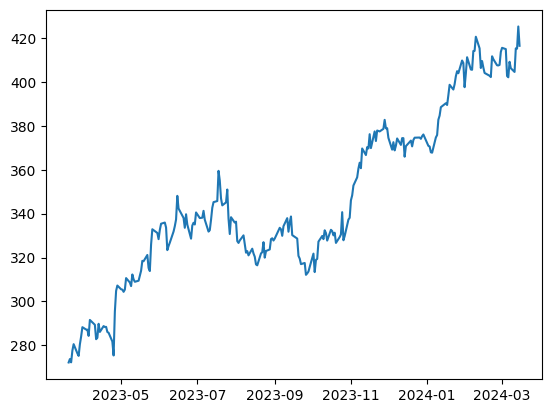

In [92]:
df = df.sort_values(by='Date')
plt.plot(df['Date'], df['Close'])

In [94]:
def create_features(dataFrame, n_days):

    for n in range(1, n_days + 1):
        dataFrame[f'Close_{n}d_ago'] = dataFrame['Close'].shift(n)
        column_order = [f'Close_{n}d_ago' for n in range(n_days, 0, -1)]
       
    dataFrame = dataFrame.dropna().reset_index(drop=True)
    dataFrame = dataFrame[['Date'] + column_order + ['Close']]
    return dataFrame

n_days = 5
df = create_features(df, n_days)

        Date  Close_5d_ago  Close_4d_ago  Close_3d_ago  Close_2d_ago  \
0 2023-03-27           NaN           NaN           NaN           NaN   
1 2023-03-28           NaN           NaN           NaN           NaN   
2 2023-03-29           NaN           NaN           NaN    276.380005   
3 2023-03-30           NaN           NaN    276.380005    275.230011   
4 2023-03-31           NaN    276.380005    275.230011    280.510010   

   Close_1d_ago       Close  
0           NaN  276.380005  
1    276.380005  275.230011  
2    275.230011  280.510010  
3    280.510010  284.049988  
4    284.049988  288.299988  


Splitting Data

In [95]:
def df_to_X_Y(dataFrame):
    df_as_np = dataFrame.to_numpy()
    dates = df_as_np[:, 0]
    prices = df_as_np[:, 1:-1]
    X = prices.reshape((len(dates), prices.shape[1], 1))
    Y = df_as_np[:, -1]
    return dates, X.astype(np.float32), Y.astype(np.float32)

date, X_data, Y_data = df_to_X_Y(df)
date.shape, X_data.shape, Y_data.shape

((240,), (240, 5, 1), (240,))

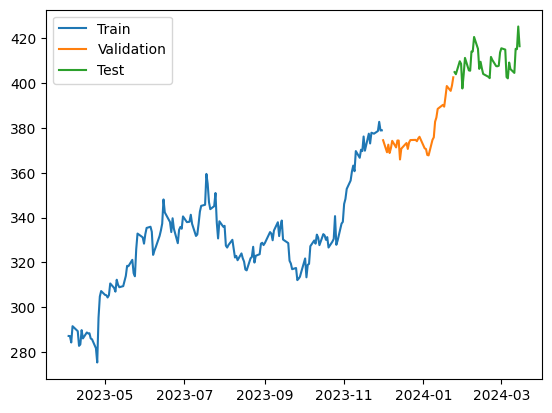

In [24]:
train_end = int(len(date) * 0.70)
test_start = train_end + int(len(date) * 0.15)

dates_train = date[:train_end]
xTrain = X_data[:train_end]
yTrain = Y_data[:train_end]


dates_val = date[train_end:test_start]
xVal = X_data[train_end:test_start]
yVal = Y_data[train_end:test_start]

dates_test = date[test_start:]
xTest = X_data[test_start:]
yTest = Y_data[test_start:]

plt.plot(dates_train, yTrain)
plt.plot(dates_val, yVal)
plt.plot(dates_test, yTest)
plt.legend(['Train', 'Validation', 'Test'])

Build the Model

In [403]:
stock_model = Sequential([layers.Input((n_days, 1)),
                    layers.LSTM(128),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

stock_model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.00001),
              metrics=['mean_absolute_error'])

Training

In [404]:
stock_model.fit(xTrain, yTrain, 
          validation_data=(xVal, yVal),
          epochs=1000,
          batch_size=2)

Epoch 1/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 107021.5859 - mean_absolute_error: 326.3171 - val_loss: 142026.2188 - val_mean_absolute_error: 376.7728
Epoch 2/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 107218.6016 - mean_absolute_error: 326.7072 - val_loss: 141804.3125 - val_mean_absolute_error: 376.4782
Epoch 3/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 107521.1250 - mean_absolute_error: 327.1120 - val_loss: 141655.4375 - val_mean_absolute_error: 376.2805
Epoch 4/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106999.6406 - mean_absolute_error: 326.1948 - val_loss: 141499.6094 - val_mean_absolute_error: 376.0734
Epoch 5/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 105276.4531 - mean_absolute_error: 323.7411 - val_loss: 141327.8906 - val_mean_absolute_error: 375.8450
Epoch 6/1000
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 107151.1797 - mean_absolute_error: 326.3818 - val_loss: 141112.0312 - val_mean_absolute_error: 375.5577
Epoch 7/1000
86/

Load the Model

In [412]:
stock_model = keras.models.load_model('stock_model.keras')

Predictions

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


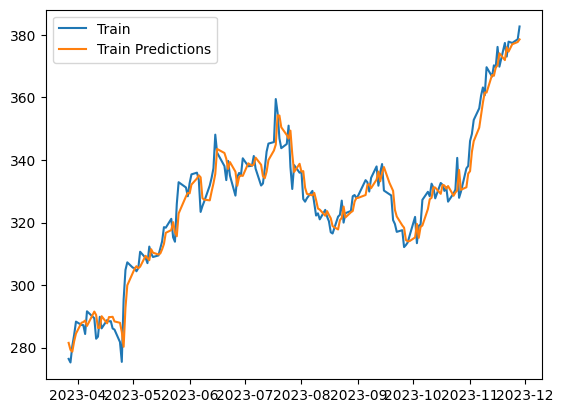

In [413]:
trainPredictions = stock_model.predict(xTrain).flatten()

plt.plot(dates_train, yTrain)
plt.plot(dates_train, trainPredictions)
plt.legend(['Train', 'Train Predictions'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


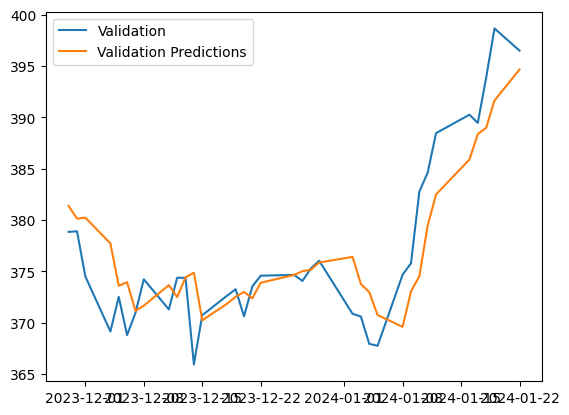

In [414]:
valPredictions = stock_model.predict(xVal).flatten()

plt.plot(dates_val, yVal)
plt.plot(dates_val, valPredictions)
plt.legend(['Validation', 'Validation Predictions'])    

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


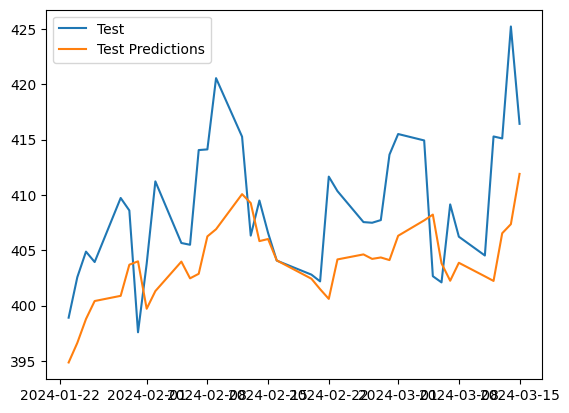

In [415]:
testPredictions = stock_model.predict(xTest).flatten()

plt.plot(dates_test, yTest)
plt.plot(dates_test, testPredictions)
plt.legend(['Test', 'Test Predictions'])

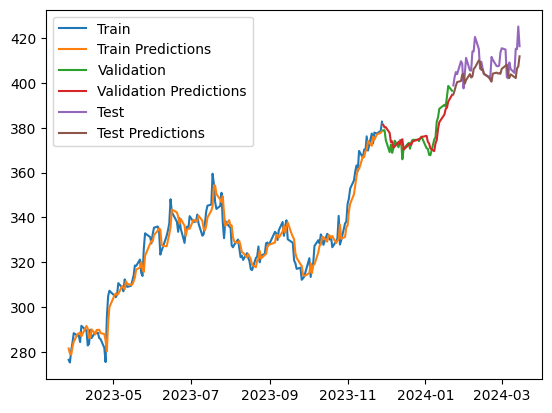

In [416]:
plt.plot(dates_train, yTrain)
plt.plot(dates_train, trainPredictions)
plt.plot(dates_val, yVal)
plt.plot(dates_val, valPredictions)
plt.plot(dates_test, yTest)
plt.plot(dates_test, testPredictions)
plt.legend(['Train', 'Train Predictions', 'Validation', 'Validation Predictions', 'Test', 'Test Predictions'])

Save the Model

In [410]:
stock_model.save('stock_model.keras')